In [2]:
import spotipy
import spotipy.util as util
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import time
import seaborn as sns
import numpy as np
import itertools
import os
import os.path
from os import path
import yaml
from collections import Counter

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, hamming_loss, silhouette_score
from collections import Counter

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.decomposition import PCA


'''Get user token to access Spotify API. Token is refreshed periodically.'''
tokenvars = yaml.load(open('apitokens.yaml'), Loader=yaml.Loader)

# Credentials for Spotify API
username = '1242062883'
client_id = tokenvars['spotify_client_id']
client_secret = tokenvars['spotify_client_secret']
scope = tokenvars['spotify_access_scope']

# Credentials for Deezer API
deezer_client_id = tokenvars['deezer_client_id']
deezer_client_secret = tokenvars['deezer_client_secret']

redirect_uri = 'http://127.0.0.1:8080/callback'

## API Helper Functions
The following functions, found in etl_functions.py, help me do Spotify and Deezer API calls to pull raw data, dimensionality reduce, and transform the data to prepare my dataset for exploration and model building. They are listed in the approximate order they are called, and build on each other to enable my store_data() and get_data() functions, which store and load my complete training dataset. Function details are included in the comments of etl_functions.py.

API Calls:
- get_user_track_ids(): Retrieve track ids for all tracks saved to user's Spotify library
- get_playlist_track_ids(): Run a keyword search in Spotify to return all track ids from n playlists searched
- get_track_artist_album(): Get a track title, album, and artist given a Spotify track id
- get_deezer_album_id(): Get a Deezer album id given track title, album, and artist obtained from get_track_artist_album()
- get_deezer_album_genres(): Calls get_deezer_album_id to get Deezer album ids, then gets Deezer album genres for those ids
- get_genres(): Call get_playlist_track_ids() and get_deezer_album_genres() to compile dataframe with Spotify track ids and genres
- get_audio_features(): Using Spotify track id's from get_playlist_track_ids(), get audio features for each track via Spotify API
- search_and_label(): Takes in list of user's desired playlist names, then passes them as keyword queries to Spotify API using get_playlist_track_ids() to return dataframe of track id's labeled with the playlist name that returned them

Data Storage, Extract, and Transformation:
- store_data(): Calls search_and_label(), get_audio_features(), and get_genres() to assemble a dataframe with track features, genres, and labels to store. Currently passes output to csv, but will eventually store to CloudSQL database
- store_user_track_data(): Similar to store_data, but assembles dataframe with track ids, features, and genres from songs in user's Spotify library. These tracks will be categorized using the trained model to output Spotify playlists
- get_data(): Retrieves data stored using store_data(). Can be used to get data for any or all playlist names stored
- get_user_track_data(): Retrieves data stored using store_user_track_data(). Gets all user tracks with features and genres
- binarize(): Used only to prepare data for modeling / predicting playlist category. Categorical features and labels are stored and retrieved in one column per variable, so binarize() calls pandas get_dummies() to binarize categorical data for use model



In [7]:
from etlfunctions22 import get_user_track_ids, get_playlist_track_ids, get_track_artist_album, get_deezer_album_id, get_deezer_album_genres, get_genres, get_audio_features, search_and_label, store_data, store_user_track_data, get_data, get_user_track_data, binarize, get_user_playlists, create_user_playlists

In [3]:
token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://127.0.0.1:8080/callback')


In [29]:
track_data = pd.read_csv('dash_app/1242062883_trackdata.csv')
track_ids = track_data['trackid'].values.tolist()


In [44]:
playlists=['electronic dance music', 'study music', 'indie folk music', 'hip hop']

In [53]:
my_openai_key="7123f950ffba47a48dde223f1450b83c"
os.environ['OPENAI_API_KEY'] = my_openai_key

from langchain.llms import OpenAI, HuggingFacePipeline
from langchain.chains import LLMChain
from langchain import PromptTemplate

In [51]:
tracks = pd.read_csv('dash_app/1242062883_trackdata.csv')[['track_name', 'track_artists']].to_dict(orient='records')[:100]

scoring_template = '''
You will be given a list of playlist names which are each surrounded by a pair of "####" tokens. You will also be given a list of dictionaries where each dictionary corresponds to a song. Each dictionary identifies a song using two keys: track_artists (name of contributing artist(s)) and track_name (name of song). We'll call each of these dictionaries a "track". For each track, loop through the list of playlist names and add a key-value pair for each playlist where the key is the playlist name and the value is a score between 0 and 1 indicating how well the track fits into that playlist. 

Playlist Names: {playlist_names}
				
Tracks: {tracks}
'''

playlist_names = ''
for pl in playlists:
    playlist_names += f' #### {pl} #### '

scoring_prompt_template = PromptTemplate(
    input_variables=['playlist_names', 'tracks'],
    template=scoring_template
)

scoring_prompt = scoring_prompt_template.format(playlist_names=playlist_names, tracks=tracks)


836


In [55]:
scoring_llm = OpenAI(model='gpt-3.5-turbo')

In [56]:
scoring_chain = LLMChain(
    llm=scoring_llm,
    prompt=scoring_prompt_template,
    output_key='scored_tracks',
    verbose=False
)

scored_tracks = scoring_chain.run(
    {'playlist_names': playlist_names,
     'tracks': tracks}
)

print(scored_tracks)

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: HTTPSConnectionPool(host='api.openai.com', port=443): Max retries exceeded with url: /v1/completions (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)'))).
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: HTTPSConnectionPool(host='api.openai.com', port=443): Max retries exceeded with url: /v1/completions (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)'))).
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: E

APIConnectionError: Error communicating with OpenAI: HTTPSConnectionPool(host='api.openai.com', port=443): Max retries exceeded with url: /v1/completions (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)')))

<h1><u> Get Data here</u></h1>

In [154]:
token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')

store_user_track_data(token, deezer_client_secret)

Success: 1 unique tracks with features stored from user library in 3.5502707958221436 seconds


True

In [162]:
# User-generated list of playlist names (hardcoded for development / testing)
pl_names = ['electronic dance music', 'study music', 'indie folk music', 'hip hop', 'classic rock', 'chill lofi', 'classical',  'adventure time', 'mellow', 'happy hour', 'late night vibes', 'workout jams']

for name in pl_names:
    token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')
    try:
        store_data(name, 2000, token, deezer_client_secret)
    except:
        continue

C4oHW1qmWy7M3AI,1TQXIltqoZ5XXyfCbAeSQQ,2rpVmxAGGc18wpBREaoE0R,4vjpLMyL3ZO6aphdYr8XYw,0F3kMN9OPXr0b5metJq2M1,3BFrR2hemusNSuiuNWXUqO,01TnVDiet1DFTsyWKUKovl,6Vdyu21iT8qScU1haSjWUU,5KCbr5ndeby4y4ggthdiAb,35mvY5S1H3J2QZyna3TFe0,4frLb7nWtsz2ymBE6k2GRP,7CCCX50zGHMTuHsyKQy03l,6vBdBCoOhKHiYDDOcorfNo,285pBltuF7vW8TeWk8hdRR,3qN5qMTKyEEmiTZD38BNTT,6cSBm4mtcuFtClN6yDvjQo,1lL7Sj9AitQT7YWXs6obEq,07dRjnkeSazozZ16S07Nee,3ZCTVFBt2Brf31RLEnCkWJ,467t3218y3yihFcyDGWjr0,3zoFkjJCH2ntsad8kfRhyi,5ls62WNKHUUrdF3r1cv83T,1qDrWA6lyx8cLECdZE7TV7,2BHj31ufdEqVK5CkYDp9mA,59acp1OhcvxwVBwQJBYKuX,3AVrVz5rK8Hrqo9YGiVGN5,6wJYhPfqk3KGhHRG76WzOh,0wzPHTgOtFIDhk2rD3Au4x,4ja2gzrNh9VNigzoXfmbwD,3xKsf9qdS1CyvXSMEid6g8,3gJDgenxLephg09x86IxPs,00t7QTffOR3SA3L1BvSQVq,7vRriwrloYVaoAe3a9wJHe,6Fc9IYSkbmVwv4dlzn8hJb,1oOEkBNp4zWnkD7nWjJdog,2hfoyc7ve6xM4ZEiNIiU1B,2FTeQQ5Rg9tBpgpTF5mnhE,6QPKYGnAW9QozVz2dSWqRg,70rFIfYN7lU6iTgUIVP42w,1u4orOe6gYxeE9xKpv11Qi,3OnOomd79OjqSYHchCQ6ht,12Fkyg9lpmaz2zmKOfw2Y2,5JtvedSVWW9McnoEAPJwQm,4SWWe2OYC4mqf40Gc2

In [164]:
test = get_data('all')['data'].groupby('label').count()
test

8741 records obtained in 0.04116177558898926 seconds


,index,trackid,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
label,,,,,,,,,,,,
adventure time,746,746,746,746,746,746,746,746,746,746,746,746
classic rock,1714,1714,1714,1714,1714,1714,1714,1714,1714,1714,1714,1714
classical,238,238,238,238,238,238,238,238,238,238,238,238
electronic dance music,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297
happy hour,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112
hip hop,1257,1257,1257,1257,1257,1257,1257,1257,1257,1257,1257,1257
indie folk music,624,624,624,624,624,624,624,624,624,624,624,624
workout jams,1753,1753,1753,1753,1753,1753,1753,1753,1753,1753,1753,1753


In [5]:
data_pulled = get_data(['happy hour', 'hip hop', 'electronic dance music', 'indie folk music'])

4290 records obtained in 0.07895755767822266 seconds


In [6]:
data = data_pulled['data'].drop('trackid', axis=1)
data_wtrackid = data_pulled['data']
playlists = data_pulled['playlists']
features = data_pulled['features']
data.head()

,index,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,label,genre
0,0,0.893,0.745,-3.105,0.0571,0.06420,0.000000,0.0943,0.872,101.018,electronic dance music,Dance
1,1,0.692,0.777,-5.472,0.1900,0.12300,0.000030,0.1760,0.694,128.017,electronic dance music,Dance
2,2,0.813,0.983,-5.515,0.1530,0.00177,0.546000,0.5020,0.770,125.007,electronic dance music,Electro
3,3,0.617,0.617,-6.941,0.1220,0.00004,0.059800,0.2530,0.517,127.996,electronic dance music,Dance
4,4,0.801,0.985,-2.690,0.0647,0.02050,0.000007,0.2970,0.720,127.990,electronic dance music,Dance


### Data Exploration
Many of the graphs here will be used in the actual app data visualization to help the user understand how well-separated the playlists being chosen are in terms of features, so they know how well the model will work

Ideas:
- Compare of genre breakdowns between classes - understand how well genre distribution differentiates classes selected 
- Class size comparison - get overall sense of how well balanced the dataset is
- Compare average Spotify feature values across playlists for each feature (radar chart) - clear visual representation of how features differ on average between classes
- Compare spread across features for each playlist (kde dist plot) - see how similar distributions of features are between classes. May want to quantify using bootstrap sampling as well (null hypothesis: between two classes, the values for a given feature belong to the same distribution).
- Count how many overlaps each playlist had with the other playlists (2^n - n possible combinations) - another similarity measure between playlists
- Check multicollinearty between features using correlation matrix - ensure features don't correlate strongly with each other, as this is an assumption in most of the models I plan to try.

In [130]:
# Set theme
sns.set(style="whitegrid")

In [183]:
top_genres = pd.DataFrame(columns=['Rank'] + playlists)
for pl in playlists:
    data_slice = data[data['label']==pl]
    genre_counts = data_slice.groupby(['genre'])['index'].count().sort_values(ascending=False).reset_index(name='count')
    total_tracks = len(data_slice.index)
    for index, row in genre_counts.iterrows():
        genre_counts.at[index, 'percent'] = '{:.0f}'.format(row['count']/total_tracks*100) + '%'
    for index, row in genre_counts.iloc[0:3, :].iterrows():
        top_genres.at[index, 'Rank'] = index + 1
        top_genres.at[index, pl] = row['genre'] + ': ' + row['percent']

  Rank      workout jams           hip hop electronic dance music  \
0    1  Rap/Hip Hop: 39%  Rap/Hip Hop: 80%             Dance: 60%   
1    2          Pop: 25%           R&B: 9%           Electro: 32%   
2    3         Rock: 14%           Pop: 8%                Pop: 5%   

   indie folk music  
0  Alternative: 63%  
1         Rock: 11%  
2          Folk: 8%  


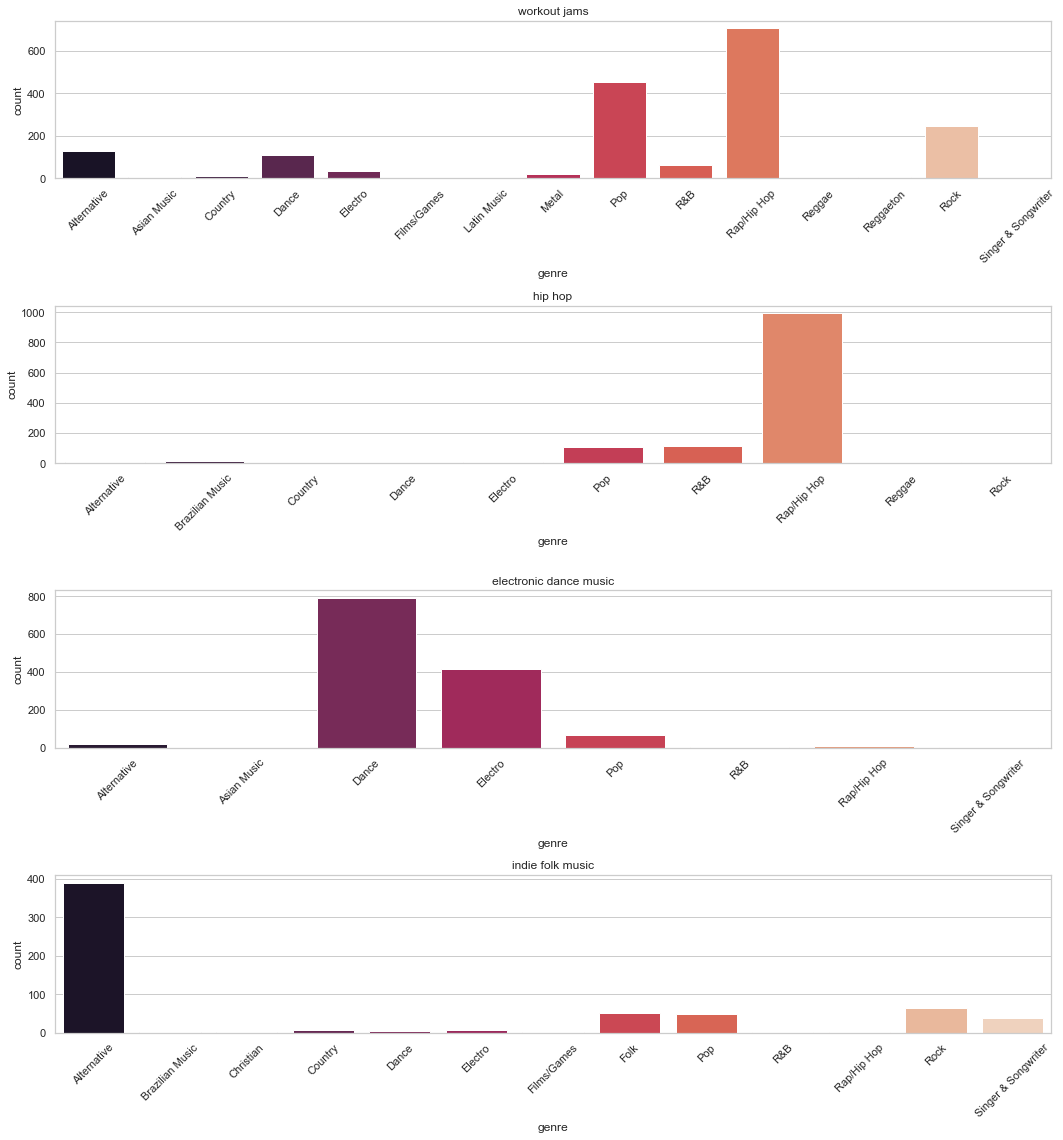

In [131]:
''' Genre breakdown '''
fig, ax = plt.subplots(len(playlists), 1, figsize=(15, 4*len(playlists)))

row = 0

for pl in playlists:
    genre_graph_data = data[data['label']==pl].groupby('genre', as_index=False).agg(
        count=pd.NamedAgg(column='genre', aggfunc='count')
    )
    plot = sns.barplot(ax=ax[row], x='genre', y='count', data=genre_graph_data, palette='rocket')
    ax[row].set_title(pl)
    for item in plot.get_xticklabels():
        item.set_rotation(45)
    row += 1
plt.tight_layout()
plt.show()

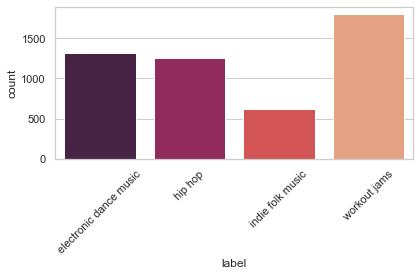

In [132]:
''' Barplot of class sizes '''
class_sizes = data.groupby('label', as_index=False).agg(
    count=pd.NamedAgg(column='label', aggfunc='count')
)

plot = sns.barplot(x='label', y='count', data=class_sizes, palette='rocket')
for item in plot.get_xticklabels():
        item.set_rotation(45)
plt.tight_layout()

   label  danceability    energy  loudness  speechiness  acousticness  \
0    NaN      0.209819  0.235742  0.251897    -0.269948     -0.249879   
1    NaN      1.349354 -0.056698  0.223741     1.668802     -0.521313   
2    NaN     -0.101461  1.311403  1.135748    -0.413216     -0.912176   
3    NaN     -1.457712 -1.490447 -1.611386    -0.985638      1.683368   

   instrumentalness  liveness   valence     tempo                playlist  
0         -1.130578 -0.371858  1.123220  0.015431              happy hour  
1         -0.755154  0.816242  0.815214 -0.979890                 hip hop  
2          1.375037  1.022141 -0.656935  1.616797  electronic dance music  
3          0.510694 -1.466526 -1.281499 -0.652338        indie folk music  


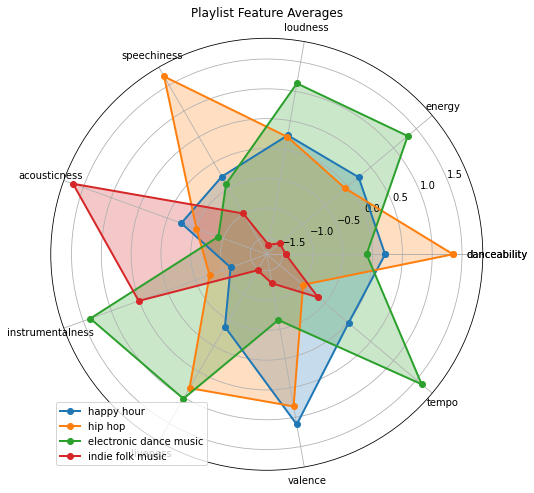

In [15]:
'''
Radar chart to compare average feature values between playlists

Generate dataframe with n rows for n playlists and feature values in the columns.
1. Reshape dataframe so each row has a playlist name of a song with the song's features
2. Take the mean for each column within the playlist name
3. Normalize the columns for each feature

playlist | feature 1 | feature 2 | feature 3 | ... 
---------+-----------+-----------+-----------+ ...
pl_1     |    0.5    |    0.8    |    0.9    | ...

'''

pls_df = pd.DataFrame(columns = ['label'] + features)

for item in playlists:
    pl_df = data[data['label']==item]
    pl_df = pl_df[['label'] + features]
    pl_averages = pl_df.groupby('label', as_index=False).mean()
    pls_df = pls_df.append(pl_averages, ignore_index=True)

stdscaler = StandardScaler()

pls_df_scaled = pd.DataFrame(columns = ['label'] + features)
pls_df_values_scaled = stdscaler.fit_transform(pls_df[features].values)

i = 0
for row in pls_df_values_scaled:
    pls_df_scaled_row = dict(zip(features, row))
    pls_df_scaled_row['playlist'] = playlists[i]
    pls_df_scaled = pls_df_scaled.append(pls_df_scaled_row, ignore_index=True)
    i+=1

fig = plt.figure()
ax = fig.add_axes([0.30, 0.2, 1.5, 1.5], polar=True)
labels = np.array(features)

print(pls_df_scaled)

for index, row in pls_df_scaled.iterrows():
    stats = pls_df_scaled.loc[index, labels].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, np.array(features + [features[0]]))
    ax.legend(playlists)
    ax.grid(True)

plt.title('Playlist Feature Averages')
plt.show()

In [197]:
test = data.groupby('label').mean().drop('index', axis=1)
print(test)
print(test.loc['electronic dance music'].values)

                        danceability    energy  loudness  speechiness  \
label                                                                   
electronic dance music      0.638411  0.796500 -5.032904     0.073846   
hip hop                     0.750250  0.649257 -6.503869     0.194761   
indie folk music            0.539545  0.492048 -9.559237     0.039970   
workout jams                0.683675  0.732565 -5.499998     0.134732   

                        acousticness  instrumentalness  liveness   valence  \
label                                                                        
electronic dance music      0.086934          0.123076  0.202621  0.422385   
hip hop                     0.150371          0.024240  0.195276  0.552533   
indie folk music            0.482548          0.079562  0.155101  0.371092   
workout jams                0.104465          0.013176  0.198496  0.542742   

                             tempo  
label                               
electronic dance m

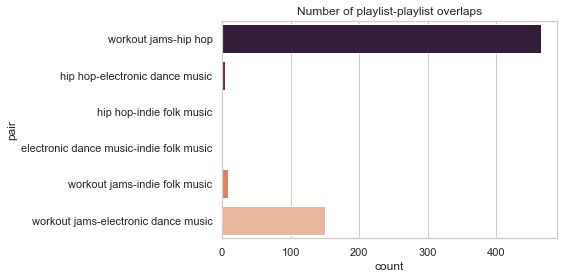

In [134]:
'''
Overlap summary graph: Count how many times each playlist overlaps with another playlist (n(n-1)/2 possible combinations)
Requires generation of all possible length-2 combinations of the playlists selected, filtering to instances where those combinations occur, then counting those instances
'''

n_playlists = len(playlists)
n_pairs = int(n_playlists*(n_playlists-1)/2)

# pair_inds generates all possible length-2 combinations of matches by list index in pl_names
pair_inds = list(set((itertools.combinations(list(range(n_playlists)), 2))))

pairs = [[playlists[pair_ind[0]], playlists[pair_ind[1]]] for pair_ind in pair_inds]

pairs_df = pd.DataFrame(columns=['pair', 'count'])

overlap_data = data_wtrackid.groupby('trackid', as_index=False)['trackid', 'label'].transform(lambda x: ''.join(x)).drop_duplicates()

for pair in pairs:
    pair_name = pair[0] + '-' + pair[1]
    pair_filter = (overlap_data['label'].str.contains(pair[0])) & \
                  (overlap_data['label'].str.contains(pair[1]))
    pair_count = len(overlap_data[pair_filter].index)
    pairs_df = pairs_df.append({'pair': pair_name, 'count': pair_count}, ignore_index=True)

ax = sns.barplot(x='count', y='pair', data=pairs_df, palette="rocket")
plt.title('Number of playlist-playlist overlaps')
plt.show()


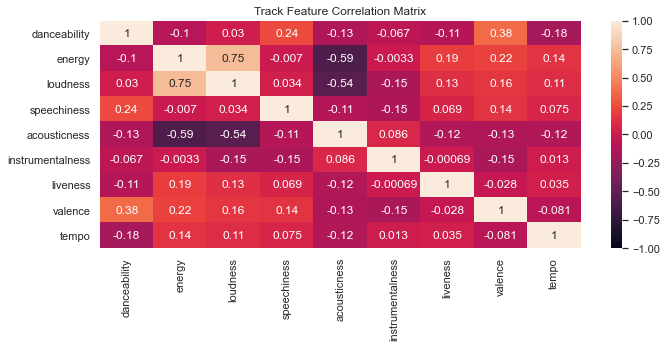

In [135]:
''' Check for multicollinearity between features '''
ppdata = data[features]

fig, ax = plt.subplots(1, figsize=(10, 5))

sns.heatmap(ppdata.corr(), ax=ax, vmin=-1, vmax=1, annot=True)
plt.title('Track Feature Correlation Matrix')

plt.tight_layout()
plt.show()

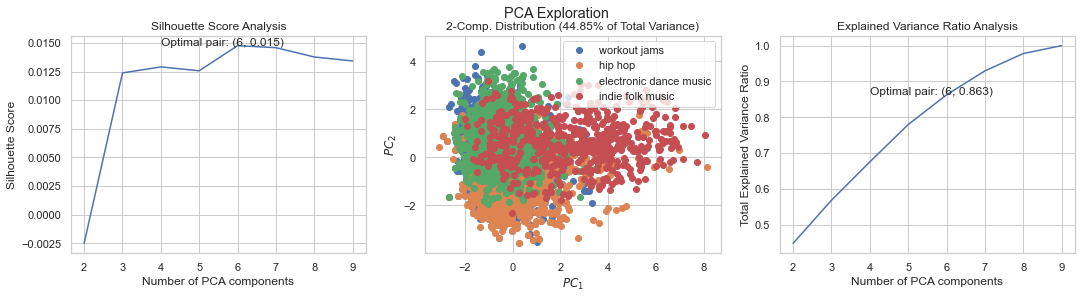

In [136]:
''' PCA - reduce feature set to 2D to visualize spread of features within classes '''
n_comps = [2, 3, 4, 5, 6, 7, 8, 9]
pca_tracker = pd.DataFrame(columns=['n_comps', 'silhouette score', 'explained variance'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('PCA Exploration')

for n_comp in n_comps:
    pca = PCA(n_components=n_comp, svd_solver='auto')

    feature_data = data[features]
    feature_data = pd.DataFrame(stdscaler.fit_transform(feature_data))
    pca_features = pd.DataFrame(pca.fit_transform(feature_data))
    pca_labels = data['label']

    transformed_data = pd.concat([pca_features, pca_labels], join='inner', axis=1)
    
    silhouette = silhouette_score(X=pca_features, labels=pca_labels)
    variance = sum(pca.explained_variance_ratio_)
    pca_tracker = pca_tracker.append({'n_comps': n_comp, 'silhouette score': silhouette, 
                                      'explained variance': variance}, ignore_index=True)

    if n_comp == 2:
        for pl in playlists:
            ax2.plot(transformed_data[pca_labels==pl][0], transformed_data[pca_labels==pl][1], 'o')
            ax2.legend(playlists)
            ax2.set_title('2-Comp. Distribution ({0:.2f}% of Total Variance)'.format(variance*100))
            ax2.set(xlabel="$PC_{" + str(1) + "}$", ylabel="$PC_{" + str(2) + "}$")

# Out of n_components that explain > 60% of total variance, consider highest silhouette score as optimal value
viable_ncomps = pca_tracker[pca_tracker['explained variance']>=0.7]
max_sil = viable_ncomps['silhouette score'].max()
best_ncomp = int(viable_ncomps[viable_ncomps['silhouette score']==max_sil]['n_comps'].to_list()[0])
opt_var = viable_ncomps[viable_ncomps['silhouette score']==max_sil]['explained variance'].to_list()[0]

ax1.plot(pca_tracker['n_comps'], pca_tracker['silhouette score'])
ax1.set_title('Silhouette Score Analysis')
ax1.set(xlabel='Number of PCA components', ylabel='Silhouette Score')
ax1.annotate('Optimal pair: ({0}, {1:.3f})'.format(best_ncomp, max_sil), xy=(best_ncomp, max_sil), 
             xytext=(best_ncomp-2, max_sil))

ax3.plot(pca_tracker['n_comps'], pca_tracker['explained variance'])
ax3.set_title('Explained Variance Ratio Analysis')
ax3.set(xlabel='Number of PCA components', ylabel='Total Explained Variance Ratio')
ax3.annotate('Optimal pair: ({0}, {1:.3f})'.format(best_ncomp, opt_var), xy=(best_ncomp, opt_var),
             xytext=(best_ncomp-2, opt_var))

plt.show()

## Model Building
<b>General solution:</b> Since I am predicting multiple classes, build multiple binary classifiers (one per class) to run in parallel that each predict whether each song does / does not belong to one class. 

<b>Evaluation Metrics:</b>
- Microaveraged F1, precision, recall: because dataset has multiple classes, TP, TN, FP, and FN will be summed across all classes to compute precision, recall, and f1 to account for class imbalances.
Note: Taking the use case into consideration, it is better for the end user to receive a smaller playlist with a higher percentage of correct entries
than a larger playlist with more erroneous entries. Therefore, a greater emphasis should be placed on maximizing TP / FP ratio while maintaining a reasonable
enough TN / FN ratio to generate a substantial playlist. In other words, precision is prioritized over recall.

<b>Model selected: Logistic Regression</b>  
Logistic Regression has high flexibility in the decision threshold, as I can adjust the probability threshold at which it predicts whether a track belongs to a class or not. This is important for my use case, as it allows me to optimize the threshold for higher precision (at the cost of recall) by increasing the threshold from default 0.5 to make the classifier more "selective". Further, the model has extremely high explainability, which is always a benefit.

## Model Building: Data Preparation

In [7]:
'''[1] Binarize training model data for genre and playlist, as they are categorical variables'''
binarizer = binarize(df=data_wtrackid, feature_var='genre', label_var='label', id_col='trackid')
model_data = binarizer['data']
model_features = model_data[features]
model_labels = binarizer['label']

In [8]:
'''[2] Get Spotify user track data. It's critical to do this here for steps [3] and [4]'''
user_spotify_data = get_user_track_data()
user_track_data = user_spotify_data['data']
user_track_features = user_spotify_data['features']

'''[3] Prepare Spotify user track data for model prediction: binarize and standardize genre column'''
binarizer_user = binarize(df=user_track_data, feature_var='genre', label_var='None', id_col='trackid')
binarized_user_data = binarizer_user['data']

1011 records obtained in 0.025931596755981445 seconds


In [16]:
'''[4] Resolve differences in dummy columns generated for model data vs. Spotify user track data. Create new columns in 
both datasets as needed to ensure both datasets contain the same feature columns in the same order'''
training_set_genres = list(set(data_wtrackid['genre'].to_list()))
user_data_genres = list(set(user_track_data['genre'].to_list()))
training_set_genres_add = [genre for genre in user_data_genres if genre not in training_set_genres]
user_data_genres_add = [genre for genre in training_set_genres if genre not in user_data_genres]

for genre in training_set_genres_add:
    model_data['genre_' + genre] = 0
for genre in user_data_genres_add:
    binarized_user_data['genre_' + genre] = 0

bin_user_cols = binarized_user_data.columns.to_list()
model_data = model_data[bin_user_cols + model_labels]

binarized_user_genres = binarized_user_data.columns.to_list()

for feature in user_track_features:
    binarized_user_genres.remove(feature)

binarized_user_genres.remove('trackid')

model_genres = binarized_user_genres

In [17]:
'''[5] Remove mean and scale continuous features to unit variance'''
std_scaled_model_features = pd.DataFrame(stdscaler.fit_transform(model_features))

In [18]:
'''[6] Split training dataset into X and y for model training'''
X = pd.concat([std_scaled_model_features, model_data[model_genres]], join='inner', axis=1, ignore_index=True)
y = model_data[model_labels]

In [19]:
'''[7] Split data into test / train sets'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## Model Building: Training and Evaluation

   threshold  precision    recall        f1
0        0.1   0.607864  0.970442  0.747506
1        0.2   0.728871  0.936566  0.819767
2        0.3   0.798108  0.896712  0.844542
3        0.4   0.847777  0.867486  0.857518
4        0.5   0.881621  0.823647  0.851648
5        0.6   0.911753  0.775490  0.838119
6        0.7   0.937636  0.714048  0.810709
7        0.8   0.953746  0.630023  0.758800
8        0.9   0.967614  0.486217  0.647215


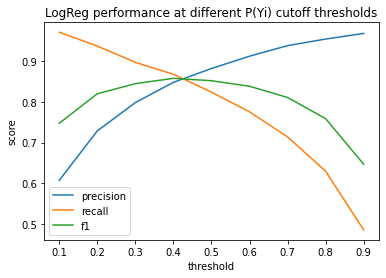

In [20]:
'''[1] Logistic Regression with adjusted probability threshold'''
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
multilogreg.fit(X_train, y_train)

pred_proba_df = pd.DataFrame(multilogreg.predict_proba(X_train))

threshold_scores = pd.DataFrame({'threshold':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

for index, row in threshold_scores.iterrows():
    i = row['threshold']
    y_train_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)

    threshold_scores.at[index, 'precision'] = precision_score(y_train, y_train_pred, average='micro')
    threshold_scores.at[index, 'recall'] = recall_score(y_train, y_train_pred, average='micro')
    threshold_scores.at[index, 'f1'] = f1_score(y_train, y_train_pred, average='micro')

print(threshold_scores)

for col in ['precision', 'recall', 'f1']:
    sns.lineplot(data=threshold_scores, x='threshold', y=col, palette='rocket')
    plt.ylabel('score')
    plt.legend(['precision', 'recall', 'f1'])
    plt.title('LogReg performance at different P(Yi) cutoff thresholds')

selected_threshold = threshold_scores[threshold_scores['precision']>0.9]['threshold'].min()

## Analyzing Results for Different Probability Thresholds
As expected, increasing threshold led to a tradeoff between precision and recall. The optimal point of precision and recall varies depending on the classes selected for prediction, but as a rule of thumb I'll take the lowest threshold that produces precision > 0.9.

Next step is to tune hyperparameters for Logistic Regression. Here I assume is that impact of hyperparameters, which are only focused on solver algorithm type and regularization strength, have no relationship with the impact of threshold defined earlier. So, I'll optimize Logistic Regression model for default threshold = 0.5, since cross_validate and GridSearchCV don't support custom prediction thresholds out of the box, then reapply optimal parameters for my final model, which will have a prediction threshold of 0.8.

In [21]:
'''[2] Logistic Regression hyperparameter tuning'''
# Instantiate LogisticRegression classifier (estimator) for cross validation
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

# Perform grid search cross validation for hyperparameter tuning
micro_precision = make_scorer(precision_score, average='micro')
micro_recall = make_scorer(recall_score, average='micro')
micro_f1 = make_scorer(f1_score, average='micro')

parameters = {'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'estimator__C': [0.01, 0.1, 1, 2, 10, 20]}

scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'micro_f1': micro_f1}
cv_score = {'micro_precision': micro_precision}

multilogreg_gs = GridSearchCV(multilogreg, parameters, scoring=micro_precision, refit=cv_score, return_train_score=True)
multilogreg_gs.fit(X_train, y_train)
print('Best combination: {0}\n'.format(multilogreg_gs.best_params_))

logreg_scores = cross_validate(multilogreg, X_train, y_train, scoring=scoring)
logreg_scores_optimal = cross_validate(multilogreg_gs.best_estimator_, X_train, y_train, scoring=scoring)

print('CV Scores Before Optimization:')
for key in logreg_scores:
    print('{0}: {1}'.format(key, logreg_scores[key]))

print('\nCV Scores After Optimization:')
for key in logreg_scores_optimal:
    print('{0}: {1}'.format(key, logreg_scores_optimal[key]))

Best combination: {'estimator__C': 0.01, 'estimator__solver': 'newton-cg'}

CV Scores Before Optimization:
fit_time: [0.07433987 0.06295943 0.08203006 0.08268714 0.073874  ]
score_time: [0.01993346 0.01895165 0.03061271 0.01595736 0.01701903]
test_micro_precision: [0.8655914  0.87455197 0.89454545 0.88948307 0.86013986]
test_micro_recall: [0.79966887 0.80661157 0.82828283 0.83166667 0.80921053]
test_micro_f1: [0.8313253  0.83920894 0.86013986 0.85960379 0.83389831]

CV Scores After Optimization:
fit_time: [0.0528388  0.05783463 0.05083108 0.04776645 0.05287766]
score_time: [0.01494241 0.01998186 0.02094483 0.01694798 0.02345109]
test_micro_precision: [0.86588235 0.8975     0.9195122  0.91358025 0.89135802]
test_micro_recall: [0.60927152 0.59338843 0.63468013 0.61666667 0.59375   ]
test_micro_f1: [0.71525753 0.71442786 0.75099602 0.73631841 0.71273445]


To better understand results, plotting precision score vs. C (inverse regularization strength) for different solvers below:

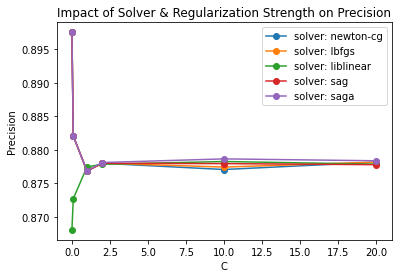

In [22]:
'''[3] Plotting GridSearchCV results: Precision vs. C for different solvers'''
gscv_scores = np.transpose(multilogreg_gs.cv_results_['mean_test_score'].reshape((len(parameters['estimator__C']),
                                                                                  len(parameters['estimator__solver']))))
for ind, i in enumerate(parameters['estimator__solver']):
    plt.plot(parameters['estimator__C'], gscv_scores[ind], marker='o', label='solver: ' + str(i))
plt.legend()
plt.title('Impact of Solver & Regularization Strength on Precision')
plt.xlabel('C')
plt.ylabel('Precision')
plt.show()

## Notes on Hyperparameter Tuning
- Since C is inverse regularization strength, would be best to keep lower if possible to encourage models less prone to overfit 
- Plan to keep C at 1 (default in sklearn) for the final model
- It appears different solvers have little impact on performance

In [23]:
'''[4] Testing Logistic Regression with adjusted probability threshold on holdout set'''
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
multilogreg.fit(X_train, y_train)

pred_proba_df = pd.DataFrame(multilogreg.predict_proba(X_test))

threshold_scores = pd.DataFrame({'threshold':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

for index, row in threshold_scores.iterrows():
    i = row['threshold']
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)

    threshold_scores.at[index, 'precision'] = precision_score(y_test, y_test_pred, average='micro')
    threshold_scores.at[index, 'recall'] = recall_score(y_test, y_test_pred, average='micro')
    threshold_scores.at[index, 'f1'] = f1_score(y_test, y_test_pred, average='micro')

print(threshold_scores)

   threshold  precision    recall        f1
0        0.1   0.595857  0.967162  0.737407
1        0.2   0.717287  0.934324  0.811545
2        0.3   0.796386  0.896013  0.843267
3        0.4   0.843272  0.862392  0.852725
4        0.5   0.871476  0.821736  0.845875
5        0.6   0.908015  0.779515  0.838873
6        0.7   0.930498  0.701329  0.799822
7        0.8   0.949214  0.613761  0.745489
8        0.9   0.967846  0.470680  0.633351


## Conclusion from evaluating precision on training / holdout sets
Results are robust between training and holdout sets. Next and final test - run the model on my own Spotify tracks to predict playlist categories and see how much I like the results.

In [24]:
user_track_ids_col = binarized_user_data['trackid']
t_bin_user_data = binarized_user_data.drop('trackid', axis=1)
t_bin_user_data = np.concatenate((stdscaler.fit_transform(t_bin_user_data[user_track_features]), 
                                  t_bin_user_data[binarized_user_genres].to_numpy()), axis=1)
t_bin_user_data.shape

(1011, 28)

In [38]:
userdata_pred_proba_df = pd.DataFrame(multilogreg.predict_proba(t_bin_user_data))

pl_pred = userdata_pred_proba_df.applymap(lambda x: 1 if x > 0.8 else 0)
pl_pred.columns = model_labels

pl_model_output = pd.concat([user_track_ids_col, pl_pred], join='inner', axis=1)
pl_predictions = pd.DataFrame(columns=['trackid', 'playlist'])

for pl in model_labels:
    pl_category = pl_model_output[pl_model_output[pl]==1]
    for index, row in pl_category.iterrows():
        pl_predictions = pl_predictions.append({'trackid': row['trackid'], 'playlist': pl.replace('label_', '')}, ignore_index=True)

In [43]:
print(pl_predictions[pl_predictions['trackid']=='01Dc5vTMc9axpkvDUy0yiD'])
test = binarized_user_data[['trackid']+features].merge(pl_predictions, how='inner', on='trackid')
print(test)

                    trackid          playlist
242  01Dc5vTMc9axpkvDUy0yiD  indie folk music
                    trackid  danceability  energy  loudness  speechiness  \
0    01Dc5vTMc9axpkvDUy0yiD         0.476   0.145   -17.652       0.0395   
1    01z2fBGB8Hl3Jd3zXe4IXR         0.272   0.238   -12.148       0.0349   
2    03IztGDdGlV4FkJsyDqVa6         0.373   0.934    -6.055       0.0463   
3    048AQ5XBnvStuTn7X2pGSY         0.538   0.804    -4.602       0.0291   
4    04Z1hAnLPmUHTKMFLFoXZe         0.703   0.611    -7.031       0.1070   
..                      ...           ...     ...       ...          ...   
312  7tfFKFzhab4584SHvAlFYB         0.628   0.485    -6.020       0.0733   
313  7uFhHMYpEC2MLXwxt64pMD         0.439   0.445    -6.972       0.0383   
314  7viVy4Pzl3vbISTFT0Y7BJ         0.402   0.284   -10.722       0.0481   
315  7yLdsSgvUrUXlSlpfBuoCA         0.688   0.509    -6.762       0.3180   
316  7z4hUzuhWm64LDn0Qbyv5y         0.677   0.409    -6.796       0.0461

In [149]:
token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')

create_user_playlists(pl_predictions, token, username)

workout jams
hip hop
electronic dance music
indie folk music
Playlists created successfully


True

In [150]:
''' Create evaluation metric for predicted playlists. Note: input data must be scaled for this analysis '''
# Get dataframe of average sample distance from centroid for each class
differences_df = pd.DataFrame(columns=['playlist', 'avg difference', 'stddev difference'])
pl_averages = pd.DataFrame(columns=['label'] + features)
mmscaler = MinMaxScaler()

for item in playlists:
    tracklevel_df = data[data['label']==item].reset_index()
    scal_features = pd.DataFrame(mmscaler.fit_transform(tracklevel_df[features]), columns=features)
    tracklevel_df = pd.concat((tracklevel_df['label'], scal_features), axis=1, join='inner')
    tracklevel_df.columns = ['label'] + features
    pl_averages = pl_averages.append(tracklevel_df.groupby('label', as_index=False).mean())
    pl_feature_averages = pl_averages[features].to_numpy()

    for index, row in tracklevel_df.iterrows():
        feature_values = row[features].to_numpy()
        tracklevel_df.at[index, 'distance_from_avg'] = np.linalg.norm(feature_values - pl_feature_averages)
    
    avg_dist = tracklevel_df['distance_from_avg'].mean()
    stddev_dist = tracklevel_df['distance_from_avg'].std()
    differences_df = differences_df.append({'playlist': item, 'avg difference': avg_dist, 'stddev difference': stddev_dist}, ignore_index=True)

                 playlist  within average  within +1 std  beyond +1 std
0            workout jams        0.000000       0.000000       1.000000
1                 hip hop        0.000000       0.023810       0.976190
2  electronic dance music        0.069231       0.438462       0.561538
3        indie folk music        0.291262       0.728155       0.271845


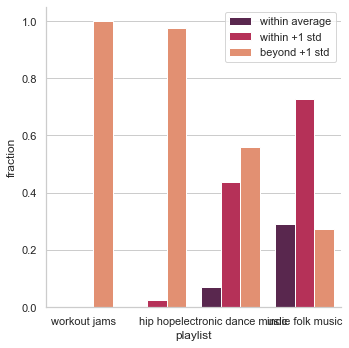

In [151]:
# Calculate percentage of samples from user library that are < avg difference, < avg distance + 1 std, > avg distance + 1 std away from training centroid for their class
labeled_user_track_data = user_track_data.merge(pl_predictions, how='inner', on='trackid')
data_closeness = pd.DataFrame(columns=['playlist', 'within average', 'within +1 std', 'beyond +1 std'])

for item in playlists:
    user_tracklevel_df = labeled_user_track_data[labeled_user_track_data['playlist']==item].reset_index()
    user_scal_features = pd.DataFrame(mmscaler.fit_transform(user_tracklevel_df[features]), columns=features)
    user_tracklevel_df = pd.concat((user_tracklevel_df['playlist'], user_scal_features), axis=1, join='inner')
    user_tracklevel_df.columns = ['label'] + features  

    training_record = differences_df[differences_df['playlist']==item]
    training_avg = training_record['avg difference'].values[0]
    training_std = training_record['stddev difference'].values[0]


    for index, row in user_tracklevel_df.iterrows():
        user_feature_values = row[features].to_numpy()
        user_tracklevel_df.at[index, 'distance_from_avg'] = np.linalg.norm(user_feature_values - pl_feature_averages)
    
    total_entries = len(user_tracklevel_df.index)
    within_avg = user_tracklevel_df[user_tracklevel_df['distance_from_avg'] <= training_avg].count().values[0] / total_entries
    within_std = user_tracklevel_df[user_tracklevel_df['distance_from_avg'] <= training_avg + training_std].count().values[0] / total_entries
    beyond_std = user_tracklevel_df[user_tracklevel_df['distance_from_avg'] > training_avg + training_std].count().values[0] / total_entries

    data_closeness = data_closeness.append({'playlist': item, 
                                            'within average': within_avg, 
                                            'within +1 std': within_std,
                                            'beyond +1 std': beyond_std}, ignore_index=True)
print(data_closeness.head())

data_closeness_plot = pd.melt(data_closeness, id_vars='playlist', var_name='closeness', value_name='fraction')
plot = sns.catplot(x='playlist', y='fraction', hue='closeness', data=data_closeness_plot, kind='bar', palette='rocket', legend=False)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()